#### Imports

In [1]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import matplotlib
import time
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [2]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


In [3]:
importlib.reload(data)
eigen_energies, emin, emax = data.load_eigenenergies(unpack = True, n_structures = n_structures)

This file contains the eigenenergies and their corresponding kpoints of the training Silicon structures generated using DFT PBE as implemented in FHI-AIMS version 171221_1 with the ``tight'' settings


In [4]:
print (emin)

-24.553719539983


In [5]:
print (emax)

11.346414696331


In [6]:
# gb = 0.3 #eV
# dE = 0.05 #eV

# # build the DOS of the dataset, 
# # normalized by number of atoms and number of eigenvalues
# xdos2, ldos2 = utils.build_dos(gb, eigen_energies, dE, emin, emax, n_atoms) #sigma, eigenvalues, dx, emin, emax

# xdos2_tensor = torch.tensor(xdos2)
# ldos2 *= 2
# ldos2 = torch.tensor(ldos2)

## Features PCA

In [7]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


## Translation invariant Loss function

In [8]:
import dostools.loss.loss as loss

# importlib.reload(loss)
# with torch.no_grad():
#     shift_range = torch.tensor([0.05 * a for a in torch.arange(-5,5)])
#     #shift_range = torch.tensor([0])
#     a = loss.t_get_BF_shift_rmse(reconstructed_ldos_t, ldos, shift_range, xdos, perc = True)
#     print (a)

In [9]:
# z = (torch.sum((structure_coefficients_t[train_index].view(1, 831, 687) * (torch.exp(-0.5*((alignment.view(1,-1,1) + xdos.view(-1,1,1) - structure_eigvals_t[train_index])/sigma)**2))), dim = 2)).T * normalization[train_index].view(-1,1) * 2


## Dataset and Dataloader

In [10]:
structure_coefficients_t = torch.load('structure_coefficients.pt')
structure_eigvals_t = torch.load('structure_eigvals.pt')
reconstructed_ldos_t = torch.load('reconstructed_ldos.pt')

sigma = 0.3
dx = 0.05

full_eigen_energies = [torch.tensor(i.flatten()) for i in eigen_energies]
eigenenergy_length = [len(i) for i in full_eigen_energies]
eigenenergy_length_t = torch.tensor(eigenenergy_length)
# small_index = (eigenenergy_length_t<10000)
# small_index = small_index.nonzero()
# small_index = small_index.flatten()
n_atoms_t = torch.tensor(n_atoms)
normalization_eiglength = [len(i) for i in eigen_energies]
normalization_eiglength_t = torch.tensor(normalization_eiglength)
normalization = 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms_t/normalization_eiglength_t



In [11]:
from torch.utils.data import Dataset
class ShiftingDataset(Dataset):
    def __init__(self, X, y_coeff, y_eigval, normalization, xdos):
        self.X = X
        self.y_coeff = y_coeff
        self.y_eigval = y_eigval
        self.normalization = normalization
        self.alignment = torch.nn.parameter.Parameter(torch.zeros(len(X)))
        self.xdos = xdos
        
        
    def __len__(self):
        return len(self.X)
    
    def project_dos(self, idx):
        new_dos = (torch.sum((self.y_coeff[idx].view(1, -1, 687) * (torch.exp(-0.5*((self.alignment[idx].view(1,-1,1) + self.xdos.view(-1,1,1) - self.y_eigval[idx])/sigma)**2))), dim = 2)).T * self.normalization[idx].view(-1,1) * 2
        return new_dos.squeeze()
    
    def __getitem__(self, idx):
        y = self.project_dos(idx)
        return self.X[idx], y.double()
        

In [12]:
##Remeber to save the good struct coeffs and eigvals and integrate into the database folder

In [13]:
from torch.utils.data import TensorDataset, DataLoader
# soap_dataset = ShiftingDataset(Silicon.Features['structure_avedescriptors'][:10].double(), structure_coefficients_t[:10], structure_eigvals_t[:10], normalization[:10], xdos)
soap_dataset = ShiftingDataset(Silicon.Features['structure_avedescriptors'][train_index].double(), structure_coefficients_t[train_index], structure_eigvals_t[train_index], normalization[train_index], xdos)
device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
soap_dataloader = DataLoader(soap_dataset, batch_size = 8, shuffle = True,**kwargs)

In [14]:
for x,y in soap_dataloader:
    print (x.shape)
    print (y.shape)
    break

torch.Size([8, 448])
torch.Size([8, 778])


## Model

In [147]:
import dostools.models.models as models
import dostools.models.training as training
import dostools.models.architectures as architecture
import dostools.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)

#can consider normalization layer here, start with bias and stuff first

class WassLinearModel(nn.Module):
    def __init__(self, inputSize, outputSize, xdos, device):
        super(WassLinearModel, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize, bias = True)
        self.xdos = xdos
        self.device = device
        #self.alignment = torch.zeros(train_size, device = self.device)
        self.to(self.device)

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.linear(x)
        return out
    
    

In [152]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [153]:
model1 = WassLinearModel(448, 778, xdos, "cpu")
# model1.load_state_dict(torch.load('./DynamicAdam.pt'))
# soap_dataset.alignment = torch.load('DynamicAdam_trainalignment')

  0%|                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


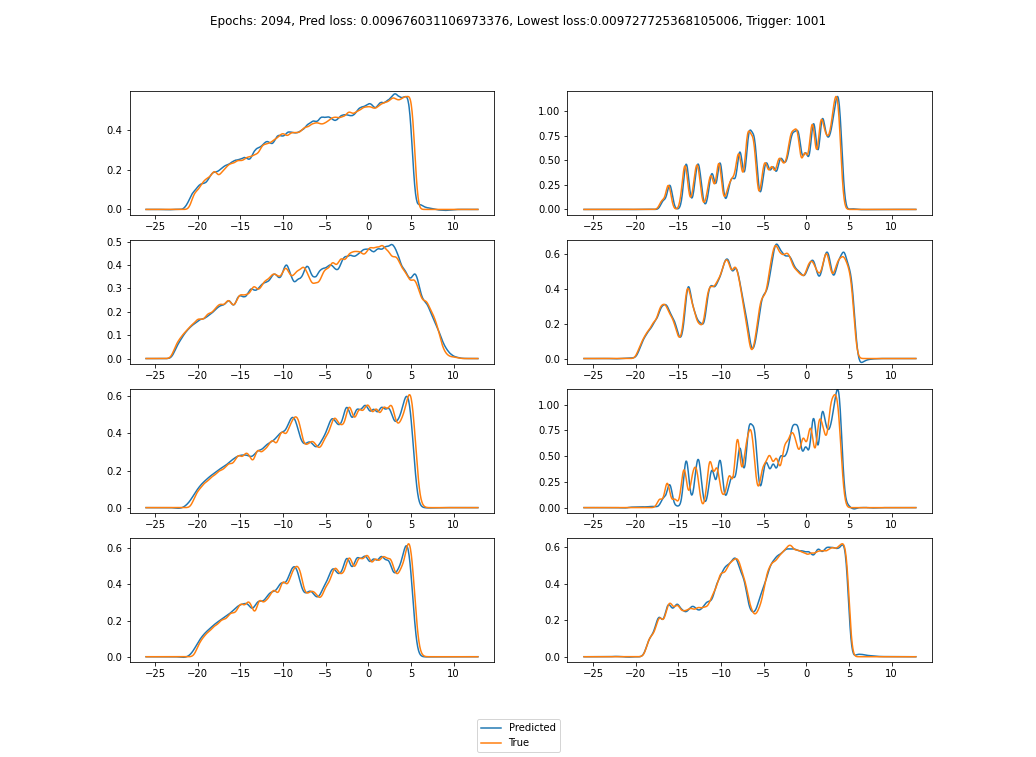

/tmp/ipykernel_9427/2665746901.py:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
Epoch: 2094:  21%|████████████████████▌                                                                             | 2094/10000 [1:39:52<6:17:06,  2.86s/it, lowest_loss=0.00973, pred_loss=8.78e-5, trigger=1000]

Implemented early stopping with lowest_loss: 0.009727725368105006


In [154]:
n_epochs = 10000
lr_model = 0.001
lr_alignment = 0.01

# if self.opt == "Adam":
opt_model = torch.optim.Adam(model1.parameters(), lr = lr_model, weight_decay = 0)
opt_alignment = torch.optim.Adam([soap_dataset.alignment], lr = lr_alignment, weight_decay = 0)
# if valdata_loader is not None:
#     threshold = 1000
#     scheduler_threshold = 100
# else:
threshold = 1000
scheduler_threshold = 100
tol = 1e-4
# if self.opt == "LBFGS":
#     opt = torch.optim.LBFGS(self.parameters(), lr = lr, line_search_fn = "strong_wolfe")
#     if valdata_loader is not None:
#         threshold = 2000
#         scheduler_threshold = 2000
#     else:
#         threshold = 30
#         scheduler_threshold = 5
#     tol = 1e-4
scheduler_model = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_model, factor = 0.1, patience = scheduler_threshold)#0.5)
scheduler_alignment = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_alignment, factor = 0.1, patience = scheduler_threshold)
best_state = copy.deepcopy(model1.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))

fig, ax_list = plt.subplots(4,2)
ax_list = ax_list.flatten()
lines = []
critical_indexes = np.arange(8)
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(model1.xdos.cpu(), reconstructed_ldos_t[train_index[critical_indexes[i]]], label = "Prediction")
    lines.append(line)
    z = ax_list[i].plot(model1.xdos.cpu(), reconstructed_ldos_t[train_index[critical_indexes[i]]], label = "True")
fig.legend([line,z], labels = ["Predicted", "True"], loc = "lower center")
for epoch in pbar:
    total_error = 0
    pbar.set_description(f"Epoch: {epoch}")
#     if valdata_loader is not None:
#         pbar.set_postfix(val_loss = lowest_loss.item(), trigger = trigger, train_loss = pred_loss.item())
#     else:
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

    for x_data, y_data in soap_dataloader:
        opt_model.zero_grad()
        opt_alignment.zero_grad()
        x_data, y_data = x_data.to(model1.device), y_data.to(model1.device)
#         if self.opt == "LBFGS":
#             def closure(predictions = False):
#                 """
#                 Function is necessary for LBFGS, returns the total loss of the model

#                 Args:
#                     predictions (bool, optional): Returns prediction loss if true, returns total loss if False

#                 Returns:
#                     tensor: Loss
#                 """
#                 opt.zero_grad()
#                 _pred = self.forward(x_data)
#                 _pred_loss = t_get_mse(_pred, y_data)#, self.xdos), perc = True)       
#                 _pred_loss *= 1e7
#                 #self.alignment = (self.alignment - 20) * (self.xdos[1] - self.xdos[0])
#                 _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
#                 _reg_loss = torch.sum(torch.pow(self.linear.weight,2))
#                 _reg_loss *= self.reg.item()
#                 _new_loss = _pred_loss + _reg_loss
#                 _new_loss.backward()
#                 # global z 
#                 # z = (torch.sum(abs(self.linear.weight.grad)))
#                 if predictions:
#                     return _pred_loss
#                 return _new_loss
#             opt.step(closure)
#             #print (z)
#             with torch.no_grad():
#                 pred = self.forward(x_data)
#                 pred_loss = t_get_rmse(pred, y_data)
#                 reg_loss = torch.sum(torch.pow(self.linear.weight,2))
#                 reg_loss *= self.reg.item()
#                 new_loss = pred_loss + reg_loss
#             if pred_loss >100000 or (pred_loss.isnan().any()) :
#                 print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
#                 self.load_state_dict(best_state)
#                 opt = torch.optim.LBFGS(self.parameters(), lr = lr)
#             if epoch %10 == 1:
#                 loss_history.append(lowest_loss.item())
#         elif self.opt == "Adam":
        pred = model1.forward(x_data)

    
        pred_loss = loss.t_get_mse(pred, y_data)#, self.xdos, perc = True)
        total_error += pred_loss
        new_loss = 1E7 * pred_loss
        new_loss.backward()
        opt_model.step()
        opt_alignment.step()
        if pred_loss >100000 or (pred_loss.isnan().any()) :
            print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
            model1.load_state_dict(best_state)
            opt = torch.optim.Adam(model1.parameters(), lr = lr, weight_decay = 0)

    with torch.no_grad():
        critical_pred = model1.forward(soap_dataset.X[critical_indexes])
        new_loss = total_error
        scheduler_model.step(new_loss)
        scheduler_alignment.step(new_loss)
        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(model1.state_dict())
            lowest_loss = new_loss
            trigger = 0
        else:
            trigger +=1
        if epoch %1000 == 1:
            loss_history.append(lowest_loss.item())
        for i in range(len(critical_indexes)):
            lines[i].set_ydata(critical_pred[i].detach().numpy())
        fig.suptitle("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()

        if trigger > threshold:
            model1.load_state_dict(best_state)
            print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
            break


In [ ]:
# torch.save(model1.state_dict(), "./DynamicAdam.pt")

In [ ]:
# torch.save(soap_dataset.alignment, "./DynamicAdam_trainalignment")

In [158]:
old_alignment = torch.load("./DynamicAdam_trainalignment")

In [18]:
import dostools.loss.loss as loss
importlib.reload(loss)
#t_get_BF_shift_index_error
# importlib.reload(loss)
# with torch.no_grad():
#     shift_range = torch.tensor([0.05 * a for a in torch.arange(-5,5)])
#     #shift_range = torch.tensor([0])
#     a = loss.t_get_BF_shift_rmse(reconstructed_ldos_t, ldos, shift_range, xdos, perc = True)
#     print (a)

<module 'dostools.loss.loss' from '/home/how/dostools/src/dostools/loss/loss.py'>

In [23]:
_, new_dos = soap_dataset[:]

In [28]:
with torch.no_grad():
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-30,30)])
    Total_preds = model1.forward(Silicon.Features['structure_avedescriptors'])
    train_loss, train_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], ldos[train_index], shift_range, xdos, perc = False)
    test_loss, test_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], ldos[test_index], shift_range, xdos, perc = False)
    total_loss, total_indexes = loss.t_get_BF_shift_index_error(Total_preds, ldos, shift_range, xdos, perc = False)

In [29]:
with torch.no_grad():
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-30,30)])
    Total_preds = model1.forward(Silicon.Features['structure_avedescriptors'])
    atrain_loss, atrain_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], ldos[train_index], shift_range, xdos, perc = True)
    atest_loss, atest_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], ldos[test_index], shift_range, xdos, perc = True)
    atotal_loss, atotal_indexes = loss.t_get_BF_shift_index_error(Total_preds, ldos, shift_range, xdos, perc = True)

In [21]:
train_loss_abs, train_indexes_abs = loss.t_get_BF_shift_index_error(Total_preds[train_index], ldos[train_index], shift_range, xdos, perc = False)

In [30]:
z = loss.t_get_rmse(Total_preds[train_index], new_dos, xdos, perc = False)
print (z)

tensor(0.0541, grad_fn=<SqrtBackward0>)


In [31]:
z = loss.t_get_rmse(Total_preds[train_index], ldos[train_index], xdos, perc = False)
print (z)

tensor(0.1019)


In [32]:
train_loss

tensor(0.0559)

In [33]:
mldos = ldos[train_index].mean(axis = 0)
std_train = torch.sqrt((torch.trapezoid((ldos[train_index] - mldos)**2, xdos, axis=1)).mean())
mldos = ldos[test_index].mean(axis = 0)
std_test = torch.sqrt((torch.trapezoid((ldos[test_index] - mldos)**2, xdos, axis=1)).mean())
mldos = ldos.mean(axis = 0)
std_all = torch.sqrt((torch.trapezoid((ldos - mldos)**2, xdos, axis=1)).mean())

In [34]:
train_loss

tensor(0.0559)

In [35]:
train_loss

tensor(0.0559)

In [36]:
100 * train_loss / std_train

tensor(9.5086)

In [37]:
atrain_loss

tensor(9.5086)

In [38]:
shift_range[train_indexes.long()]/0.05

tensor([  5.0000,  -1.0000,  -4.0000,  -1.0000,   1.0000,  -4.0000,   0.0000,
          2.0000,  -1.0000,  -2.0000,  -1.0000,  -6.0000,  -1.0000,  -1.0000,
          2.0000,  -1.0000,  -1.0000,  -1.0000,   1.0000,   2.0000,   4.0000,
          4.0000,   2.0000,   2.0000,   2.0000,   2.0000,   1.0000,   0.0000,
         -5.0000,  -2.0000,   1.0000,   1.0000,   3.0000,  -1.0000,  -1.0000,
         -1.0000,   2.0000,   1.0000,  -1.0000,   1.0000,  -2.0000,   0.0000,
         -2.0000,  -1.0000,   4.0000,  -1.0000,   2.0000,   5.0000,   4.0000,
          3.0000,  -1.0000,  -4.0000,   1.0000,   1.0000,  -1.0000,  -4.0000,
          1.0000,   1.0000,   3.0000,   2.0000,   2.0000,   2.0000,  -1.0000,
          0.0000,  -1.0000,  -3.0000,  -1.0000,   0.0000,  -1.0000,   0.0000,
          2.0000,  -1.0000,   1.0000,   1.0000,   2.0000,   2.0000,   4.0000,
          1.0000,   0.0000,   1.0000,   0.0000,   0.0000,  -2.0000,  -7.0000,
          2.0000,   1.0000,   2.0000,   4.0000,  -1.0000,   2.00

In [39]:
100 * test_loss / std_test

tensor(10.3370)

In [40]:
atest_loss

tensor(10.3370)

In [41]:
shift_range[test_indexes.long()]/0.05

tensor([ -1.0000,  -1.0000,   2.0000,   2.0000,   3.0000,   0.0000,   2.0000,
          3.0000,   2.0000,   2.0000,   2.0000,  -1.0000,  -3.0000,   0.0000,
          2.0000,   3.0000,   0.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,
          1.0000,  -1.0000,   0.0000,   1.0000,  -1.0000,  -2.0000,   1.0000,
          0.0000,  -1.0000,  -2.0000,  -1.0000,  -4.0000,   2.0000,  -1.0000,
          1.0000,  -2.0000,  -3.0000,   3.0000,   1.0000,   2.0000,   1.0000,
        -11.0000,   0.0000,   1.0000,  -2.0000,  -1.0000,   2.0000,   1.0000,
          2.0000,  -3.0000,  -3.0000,   0.0000,   5.0000,  -1.0000,   0.0000,
         -3.0000,  -1.0000,   1.0000,   1.0000,   0.0000,   0.0000,  -1.0000,
          1.0000,   2.0000,   0.0000,   2.0000,   0.0000,   2.0000,   4.0000,
          0.0000,   2.0000,  -4.0000,  -4.0000,   3.0000,  -1.0000,   2.0000,
         -1.0000,   2.0000,   2.0000,  -1.0000,   2.0000,  -1.0000,   1.0000,
         -4.0000,   2.0000,  -3.0000,   1.0000,  -1.0000,  -1.00

In [42]:
100 * total_loss/ std_all

tensor(9.6875)

In [43]:
atotal_loss

tensor(9.6875)

In [44]:
(shift_range[total_indexes.long()]/0.05)[939:1039]

tensor([2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 2., 1., 1., 1.,
        1., 2., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 2., 1.,
        1., 2., 1., 1., 1., 1., 1., 0., 1., 0., 1., 2., 1., 1., 0., 1., 2., 1.,
        1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2.,
        1., 0., 2., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 2., 2., 1., 1., 1., 1., 1., 1.])

## Analytical

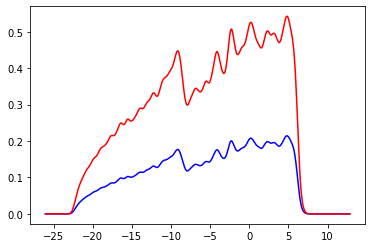

In [73]:
%matplotlib inline
plt.plot(xdos, final_ldos[600], c='b')
plt.plot(xdos, ldos[600], c= 'r')

In [163]:
#use alignment to make full dataset
sigma = 0.3
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = np.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
final_ldos = []
with torch.no_grad():
    for i in tqdm(range(len(train_index))):#for every structure    
        i_ldos = np.zeros(ndos)
        for j in (full_eigen_energies[train_index[i]]):
            i_ldos += (np.exp(-0.5*((soap_dataset.alignment[i].detach().numpy() + xdos - j.numpy())/sigma)**2))
        final_ldos.append(i_ldos * normalization[train_index[i]].detach().numpy() * 2)

#final_ldos = ((ldos.T * normalization ).T)* 2
final_ldos = np.vstack(final_ldos) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [04:28<00:00,  3.09it/s]


In [164]:
final_ldos = torch.tensor(final_ldos)

In [165]:
#def evaluate_performance(new_dos):




with torch.no_grad():
    Features = torch.hstack([Silicon.Features['structure_avedescriptors'][train_index].double(), torch.ones(len(train_index)).view(-1,1)])
    Target = final_ldos
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    Total_Features = torch.hstack([Silicon.Features['structure_avedescriptors'].double(), torch.ones(len(Silicon.Features['structure_avedescriptors'])).view(-1,1)])
    print ("training over")
    shift_range = torch.tensor([0.05 * a for a in torch.arange(-80,80)])
    Total_preds = Total_Features @ optimal_weights
    atrain_loss, atrain_indexes = loss.t_get_BF_shift_index_error(Total_preds[train_index], ldos[train_index], shift_range, xdos, perc = True)
    atest_loss, atest_indexes = loss.t_get_BF_shift_index_error(Total_preds[test_index], ldos[test_index], shift_range, xdos, perc = True)
    atotal_loss, atotal_indexes = loss.t_get_BF_shift_index_error(Total_preds, ldos, shift_range, xdos, perc = True)

print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

training over


TypeError: trapezoid() received an invalid combination of arguments - got (Tensor, numpy.ndarray, axis=int), but expected one of:
 * (Tensor y, Tensor x, *, int dim)
 * (Tensor y, *, Number dx, int dim)


In [93]:
xdos = torch.tensor(xdos)

In [94]:
loss.t_get_rmse(Features @ optimal_weights, final_ldos, xdos, perc = False)


tensor(0.0240)

In [143]:
from sklearn.linear_model import Ridge

model = Ridge(alpha = 0, fit_intercept = False, solver = 'svd')
model.fit(Features, ldos[train_index])
Total_preds = model.predict(Total_Features)

print (loss.t_get_rmse(torch.tensor(Total_preds[train_index]), ldos[train_index], xdos, perc= True))

tensor(4.6182)


In [117]:
Total_preds[train_index]

array([[-4.64694949e-12, -1.37134748e-11, -1.52624580e-11, ...,
         3.24504867e-11,  1.58344449e-11,  6.29185593e-12],
       [-7.06545933e-12, -1.76054726e-11, -3.57047725e-11, ...,
        -3.13065129e-11, -1.29709576e-11, -6.43218812e-12],
       [-1.10489395e-12, -6.59383659e-12,  5.12301312e-12, ...,
         9.56594803e-11,  4.71240824e-11,  1.74892323e-11],
       ...,
       [ 3.29691829e-12,  6.03961325e-12,  2.46558329e-11, ...,
        -4.20641300e-11, -1.85451654e-11, -8.66151595e-12],
       [ 1.65591985e-11,  3.65787400e-11,  9.71454028e-11, ...,
        -2.80955259e-11, -1.05874198e-11, -5.76938497e-12],
       [ 3.00204306e-12,  4.78905804e-12,  2.81659140e-11, ...,
        -1.56319402e-11, -4.40536496e-12, -3.38573614e-12]])

In [134]:
ldos = torch.tensor(data.load_ldos() * 2)

In [145]:
#def evaluate_performance(new_dos):

feature = Silicon.Features['structure_avedescriptors'].double()
target = ldos

with torch.no_grad():
    Features = torch.hstack([feature[train_index], torch.ones(len(train_index)).view(-1,1)])
    Target = target[train_index]
    optimal_weights = torch.linalg.lstsq(Features, Target, driver = 'gelsd').solution
    Total_Features = torch.hstack([feature, torch.ones(len(feature)).view(-1,1)])
    print ("training over")
    Total_preds = Total_Features @ optimal_weights
    atrain_loss = loss.t_get_rmse(Total_preds[train_index], target[train_index], xdos, perc = True)
    atest_loss = loss.t_get_rmse(Total_preds[test_index], target[test_index], xdos, perc = True)
    atotal_loss = loss.t_get_rmse(Total_preds, target, xdos, perc = True)

print (atrain_loss)
print (atrain_loss * std_train /100)
print (atest_loss)
print (atest_loss * std_test / 100)
print (atotal_loss)
print (atotal_loss * std_all/ 100)

training over
tensor(4.2598)
tensor(0.0251)
tensor(41.7378)
tensor(0.2542)
tensor(19.5660)
tensor(0.1159)


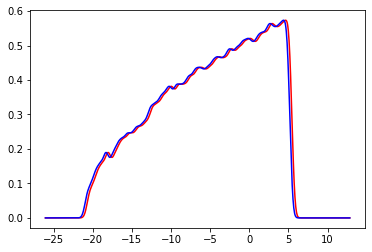

In [131]:
plt.plot(xdos, ldos[train_index[0]], c= 'r')
plt.plot(xdos, final_ldos[0], c='b')

In [109]:
loss.t_get_rmse(Total_preds[train_index], ldos[train_index], xdos, perc= True)

tensor(4.2598)

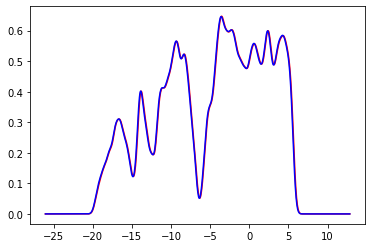

In [111]:
%matplotlib inline
i = 2
plt.plot(xdos,new_dos[i].detach().numpy(), c = 'r')
plt.plot(xdos, ldos[train_index[i]], c= 'b')

In [12]:
def generate_energy_index(eigenenergy_length):
    n_structures = len(eigenenergy_length)
    total_index = []
    for i, e_vals in enumerate(eigenenergy_length):
        indiv_index = torch.zeros(e_vals) + i
        total_index.append(indiv_index)
    total_index = torch.hstack(total_index)
    return total_index.long()

In [13]:
energy_index = generate_energy_index(eigenenergy_length)

In [14]:
energies = torch.hstack(full_eigen_energies).view(-1,1)

In [15]:
def torch_generate_dos(energies, eigenenergy_length_t, normalization, splits):
    ldoses = []
    for i in tqdm(range(len(splits) - 1)):
        indexes = generate_energy_index(eigenenergy_length_t[splits[i]:splits[i+1]])
        E = energies[torch.sum(eigenenergy_length_t[:splits[i]]):torch.sum(eigenenergy_length_t[:splits[i]]) + torch.sum(eigenenergy_length_t[splits[i]:splits[i+1]])]
        split_ldos = torch.zeros(splits[i+1] - splits[i], len(xdos))
        
        new_ldos = (torch.exp(-0.5*((xdos - E)/sigma)**2))
        
        split_ldos.index_add_(0, indexes, new_ldos)
        
        ldoses.append(split_ldos)
    ldoses = torch.vstack(ldoses)     
    
    final_ldos = ((ldoses.T * normalization ).T)* 2
    return final_ldos
    


In [16]:
# ldos2 = torch_generate_dos(energies, eigenenergy_length_t, normalization, [0, 100, 200, 300, 400, 500, 800, 1039])

In [17]:
alignment.shape

torch.Size([435])

In [18]:
lr = 100
n_epochs = 1000



In [19]:
sigma = torch.tensor(0.3)
dx = 0.05

emin = -24.5537
emax = 11.3464


ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(small_index), ndos))
for i in tqdm(range(len(small_index))):#for every structure    
    ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

final_ldos = ((ldos.T * normalization ).T)* 2

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:05<00:00, 75.96it/s]


In [20]:
loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)

In [21]:
print (loss)

tensor(212.8861, grad_fn=<SumBackward0>)


In [ ]:
lr = 0.01
alignment = torch.nn.parameter.Parameter(torch.zeros(len(small_index)))
n_epochs = 1000

optimizer = torch.optim.Adam(
                [alignment],
                lr=lr)#,  line_search_fn="strong_wolfe")

for i in tqdm(range(n_epochs)):
    def closure():
        optimizer.zero_grad()
        sigma = torch.tensor(0.3)
        dx = 0.05

        emin = -24.5537
        emax = 11.3464


        ndos = int((emax-emin+3) / dx) #number of points
        xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
        ldos = torch.zeros((len(small_index), ndos))
        for i in (range(len(small_index))):#for every structure    
            ldos[i] = torch.sum(torch.exp(-0.5*((alignment[i] + xdos - full_eigen_energies[small_index[i]].view(-1,1))/sigma)**2), dim = 0)

        final_ldos = ((ldos.T * normalization ).T)* 2
        pc_loss = torch.sum((1 - torch.abs((torch.corrcoef(torch.hstack([kernel_features, final_ldos]).T)[0][1:])))**2)
        #print (pc_loss)
        pc_loss.backward()
        return pc_loss
    
    mse = optimizer.step(closure)
    
    print (mse)

  0%|▏                                                                                                                                                                  | 1/1000 [00:09<2:45:56,  9.97s/it]

tensor(212.8861, grad_fn=<SumBackward0>)


  0%|▎                                                                                                                                                                  | 2/1000 [00:21<2:56:37, 10.62s/it]

tensor(212.1835, grad_fn=<SumBackward0>)


  0%|▍                                                                                                                                                                  | 3/1000 [00:29<2:41:25,  9.71s/it]

tensor(207.9559, grad_fn=<SumBackward0>)


  0%|▋                                                                                                                                                                  | 4/1000 [00:37<2:27:05,  8.86s/it]

tensor(204.2679, grad_fn=<SumBackward0>)


  0%|▊                                                                                                                                                                  | 5/1000 [00:45<2:25:24,  8.77s/it]

tensor(202.9791, grad_fn=<SumBackward0>)


  1%|▉                                                                                                                                                                  | 6/1000 [00:54<2:23:37,  8.67s/it]

tensor(203.2197, grad_fn=<SumBackward0>)


  1%|█▏                                                                                                                                                                 | 7/1000 [01:02<2:21:07,  8.53s/it]

tensor(203.7145, grad_fn=<SumBackward0>)


  1%|█▎                                                                                                                                                                 | 8/1000 [01:10<2:20:22,  8.49s/it]

tensor(203.2850, grad_fn=<SumBackward0>)


  1%|█▍                                                                                                                                                                 | 9/1000 [01:18<2:16:03,  8.24s/it]

tensor(202.0296, grad_fn=<SumBackward0>)


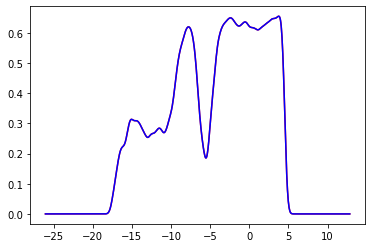

In [80]:
%matplotlib inline
index = 50
plt.plot(xdos, o_ldos[small_index[index]], c = 'r')
plt.plot(xdos, final_ldos[index].detach(), c = 'b')

torch.corrcoef
torch.var

In [24]:
tol = 1E-4
print (torch.sum(test_ldos > tol))

plt.plot(xdos[(test_ldos > tol)], test_ldos[(test_ldos > tol)])

tensor(552253)


NameError: name 'test_ldos' is not defined

In [22]:
len(xdos[(test_ldos > tol)])

NameError: name 'test_ldos' is not defined

In [212]:
ldos[0]

tensor([6.3422e-155, 5.0089e-153, 3.8472e-151, 2.8738e-149, 2.0878e-147,
        1.4751e-145, 1.0136e-143, 6.7735e-142, 4.4023e-140, 2.7826e-138,
        1.7105e-136, 1.0226e-134, 5.9460e-133, 3.3623e-131, 1.8491e-129,
        9.8900e-128, 5.1445e-126, 2.6026e-124, 1.2805e-122, 6.1272e-121,
        2.8514e-119, 1.2906e-117, 5.6807e-116, 2.4319e-114, 1.0125e-112,
        4.0999e-111, 1.6146e-109, 6.1840e-108, 2.3035e-106, 8.3453e-105,
        2.9404e-103, 1.0076e-101, 3.3580e-100,  1.0885e-98,  3.4313e-97,
         1.0520e-95,  3.1370e-94,  9.0977e-93,  2.5661e-91,  7.0396e-90,
         1.8782e-88,  4.8739e-87,  1.2301e-85,  3.0194e-84,  7.2086e-83,
         1.6738e-81,  3.7801e-80,  8.3031e-79,  1.7738e-77,  3.6858e-76,
         7.4489e-75,  1.4642e-73,  2.7993e-72,  5.2054e-71,  9.4147e-70,
         1.6562e-68,  2.8339e-67,  4.7164e-66,  7.6348e-65,  1.2021e-63,
         1.8411e-62,  2.7426e-61,  3.9740e-60,  5.6011e-59,  7.6789e-58,
         1.0240e-56,  1.3284e-55,  1.6761e-54,  2.0

In [154]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos = int((emax-emin+3) / dx) #number of points
xdos = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(full_eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos[i] *= 1/torch.sqrt(2*torch.tensor(np.pi)*sigma**2)/n_atoms[i]/len(full_eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:33<00:00,  1.28it/s]


In [181]:
sigma = torch.tensor(0.3)
dx = 0.05

ndos3 = int((emax-emin+3) / dx) #number of points
xdos3 = torch.linspace(emin-1.5, emax+1.5, ndos) # extend the energy grid by 3eV 
ldos3 = torch.zeros((len(full_eigen_energies), ndos))
for i in tqdm(range(len(eigen_energies))):#for every structure    
    for ei in full_eigen_energies[i]:#for every energy level
        ldos3[i] += torch.exp(-0.5*((xdos[:]-ei)/sigma)**2) #puts a gaussian centered on the energy level
    ldos3[i] *= 1/torch.sqrt(2*np.pi*sigma**2)/n_atoms[i]/len(eigen_energies[i]) #normalize

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1039/1039 [13:40<00:00,  1.27it/s]


In [139]:
from sklearn.decomposition import PCA

soap = Silicon.Features['structure_avedescriptors'] 
soap_pca = PCA(n_components = 1, svd_solver = "full")
soap_pca.fit(soap)

print ("SOAP PCA explained variance with 1 PCA is: {}".format(soap_pca.explained_variance_ratio_))

PCA_soap = soap_pca.transform(soap)

kernel = Silicon.Features['structure_avekerneldescriptors']
kernel_pca = PCA(n_components = 1, svd_solver = "full")
kernel_pca.fit(kernel)

print ("Kernel PCA explained variance with 1 PCA is: {}".format(kernel_pca.explained_variance_ratio_))

PCA_kernel = kernel_pca.transform(kernel)

SOAP PCA explained variance with 1 PCA is: [0.85417772]
Kernel PCA explained variance with 1 PCA is: [0.76640756]


In [146]:
soap_pca.components_

array([[-3.49913423e-03, -1.76411215e-02,  3.32522948e-02,
         3.61629233e-01,  1.87222390e-01,  7.49472932e-02,
         7.73753721e-02,  2.89413546e-02, -1.76411215e-02,
         7.01613627e-04, -6.64714922e-03, -1.96539716e-02,
        -1.21993389e-02, -6.67081254e-03, -4.36700539e-03,
        -1.68577363e-03,  3.32522948e-02, -6.64714922e-03,
         2.20352739e-02,  1.41889410e-01,  7.26851954e-02,
         3.15241013e-02,  2.88627511e-02,  1.08549650e-02,
         3.61629233e-01, -1.96539716e-02,  1.41889410e-01,
         4.92546963e-01,  2.89406316e-01,  1.51981690e-01,
         1.06534352e-01,  4.10607729e-02,  1.87222390e-01,
        -1.21993389e-02,  7.26851954e-02,  2.89406316e-01,
         1.62030561e-01,  8.08235013e-02,  6.02749031e-02,
         2.31914869e-02,  7.49472932e-02, -6.67081254e-03,
         3.15241013e-02,  1.51981690e-01,  8.08235013e-02,
         3.70043392e-02,  3.02939232e-02,  1.15274716e-02,
         7.73753721e-02, -4.36700539e-03,  2.88627511e-0

## Baseline Model (SOAP)

In [325]:
from sklearn.linear_model import Ridge
from dostools.loss import loss
from dostools.consistency import consistency

Features = copy.deepcopy(PCA_kernel)
o_ldos = torch.tensor(data.load_ldos())
o_ldos *= 2
y_pw = o_ldos# - o_ldos[train_index].mean(axis = 0)
y_shifted = copy.deepcopy(y_pw)
#y_shifted = consistency.shifted_ldos()

baselinemodel = Ridge(alpha = 0, fit_intercept = True, solver = 'svd')

x = Features[train_index]
y = y_shifted[train_index]

baselinemodel.fit(x,y)

baseline_predictions = baselinemodel.predict(x)
train_rmse = loss.t_get_rmse(torch.tensor(baseline_predictions), y)

# small_test_index = torch.arange(1039)
# small_test_index[small_index] = False
# small_test_index = small_test_index.nonzero().flatten()


baseline_test_predictions = baselinemodel.predict(Features[test_index])
test_rmse = loss.t_get_rmse(torch.tensor(baseline_test_predictions), y_shifted[test_index])

print(train_rmse)
print(test_rmse)

tensor(0.0613)
tensor(0.0636)


## Misc Visualizations

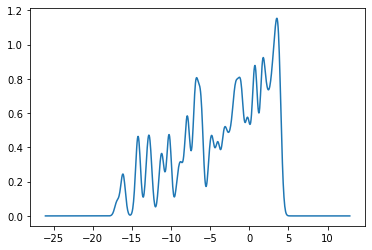

In [326]:
plt.plot(xdos, ldos[700])

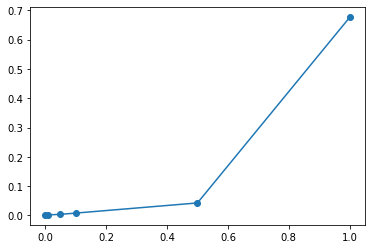

In [194]:
plt.plot(np.array([1,0.5,0.1,0.05,0.01,0.001]), np.array([0.6768, 0.0426, 0.0079, 0.0036, 0.0019, 0.0017]))
plt.scatter(np.array([1,0.5,0.1,0.05,0.01,0.001]), np.array([0.6768, 0.0426, 0.0079, 0.0036, 0.0019, 0.0017]))

In [ ]:
1
tensor(24)
tensor(0.6768)

5E-1
tensor(49)
tensor(0.0426)


1E-1
tensor(245)
tensor(0.0079)

5E-2
tensor(484)
tensor(0.0036)

1E-2 
tensor(2149)
tensor(0.0019)

1E-3
tensor(7013)
tensor(0.0017)